In [19]:
from __future__ import division
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from imutils import face_utils

### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

In [20]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

In [21]:

#Reading the dataset
dataset = pd.read_csv('fer2013.csv')

#Obtaining train data where usage is "Training"
train = dataset[dataset["Usage"] == "Training"]

#Obtaining test data where usage is "PublicTest"
test = dataset[dataset["Usage"] == "PublicTest"]

#Converting " " separated pixel values to list
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

/anaconda3/envs/Environment/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/envs/Environment/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [22]:
shape_x = 48
shape_y = 48

X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

#np.vstack stack arrays in sequence vertically (picking element row wise)
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

#Reshape X_train, y_train,X_test,y_test in desired formats
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

print("Shape of X_train and y_train is " + str(X_train.shape) +" and " + str(y_train.shape) +" respectively.")
print("Shape of X_test and y_test is " + str(X_test.shape) +" and " + str(y_test.shape) +" respectively.")

Shape of X_train and y_train is (28709, 48, 48, 1) and (28709, 1) respectively.
Shape of X_test and y_test is (3589, 48, 48, 1) and (3589, 1) respectively.


In [23]:
# Change to float datatype
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# Scale the data to lie between 0 to 1
train_data /= 255
test_data /= 255

# Change the labels from integer to categorical data
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

In [24]:

# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

# Find the shape of input images and create the variable input_shape
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

Total number of outputs :  7
Output classes :  [0 1 2 3 4 5 6]


In [25]:
#Defining labels 
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

Text(0.5, 1.0, 'Ground Truth : Surprise')

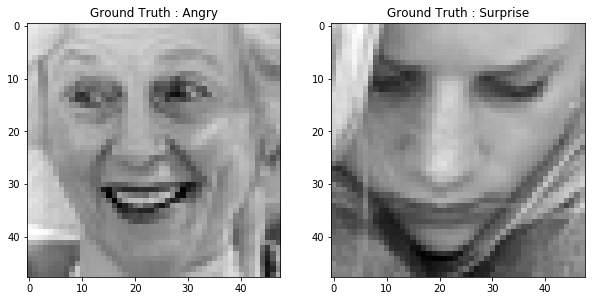

In [26]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.squeeze(X_train[25,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.squeeze(X_test[26,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500]))))

In [27]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '/usr/local/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord


In [28]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        x, y, w, h = det
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))
        
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

In [21]:
def createModel3():
    
    #Model Initialization
    model = Sequential() 
    
    model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))
    
    #Flattening
    model.add(Flatten())
    
    #Adding fully connected layer
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(512, activation='relu'))
    
    #Adding Output Layer
    model.add(Dense(nClasses, activation='softmax'))
     
    return model

In [22]:
model = createModel3()

In [23]:

layer_outputs = [layer.output for layer in model.layers[:12]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [24]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 100

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(train_data, train_labels_one_hot, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(train_data.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(test_data, test_labels_one_hot)
)

Epoch 1/100
113/113 [==============================] - 684s 6s/step - loss: 1.8017 - accuracy: 0.2468 - val_loss: 1.8391 - val_accuracy: 0.2494
Epoch 2/100
113/113 [==============================] - 650s 6s/step - loss: 1.6628 - accuracy: 0.3369 - val_loss: 1.8284 - val_accuracy: 0.2494
Epoch 3/100
113/113 [==============================] - 592s 5s/step - loss: 1.5186 - accuracy: 0.4087 - val_loss: 1.8778 - val_accuracy: 0.2246
Epoch 4/100
113/113 [==============================] - 575s 5s/step - loss: 1.4280 - accuracy: 0.4407 - val_loss: 1.5735 - val_accuracy: 0.3940
Epoch 5/100
113/113 [==============================] - 993s 9s/step - loss: 1.3650 - accuracy: 0.4678 - val_loss: 1.4146 - val_accuracy: 0.4469
Epoch 6/100
113/113 [==============================] - 1218s 11s/step - loss: 1.3210 - accuracy: 0.4896 - val_loss: 1.2475 - val_accuracy: 0.5143
Epoch 7/100
113/113 [==============================] - 604s 5s/step - loss: 1.2817 - accuracy: 0.5064 - val_loss: 1.2175 - val_accurac

In [3]:
fer_json = model.to_json()
with open("fer.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer.h5")

NameError: name 'model' is not defined

In [29]:
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [30]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [31]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [32]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

In [33]:
desiredLeftEye=(0.35, 0.35)

def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
        
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

In [ ]:
#Lancer la capture video
video_capture = cv2.VideoCapture(0)
flag = 0
j = 1
#load model
model = model_from_json(open("fer.json", "r").read())
#load weights
model.load_weights('fer.h5')

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)
    #gray, detected_faces, coord = detect_face(frame)
    
    for (i, rect) in enumerate(rects):
        
        shape = predictor_landmarks(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = gray[y:y+h,x:x+w]
        
        #Zoom sur la face extraite
        face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))
        #cast type float
        face = face.astype(np.float32)
        #scale
        face /= float(face.max())
        face = np.reshape(face.flatten(), (1, 48, 48, 1))
        prediction = model.predict(face)
        prediction_result = np.argmax(prediction)
        
        # Rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
        for (j, k) in shape:
            cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

         # 12. Add prediction probabilities
            cv2.putText(frame, "Emotional report : ",(40,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
            cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
            cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        
        # draw extracted face in the top right corner
        frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

        # 13. Annotate main image with a label
        if prediction_result == 0 :
                cv2.putText(frame, "Angry",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        elif prediction_result == 1 :
                cv2.putText(frame, "Disgust",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        elif prediction_result == 2 :
                cv2.putText(frame, "Fear",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        elif prediction_result == 3 :
                cv2.putText(frame, "Happy",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        elif prediction_result == 4 :
                cv2.putText(frame, "Sad",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        elif prediction_result == 5 :
                cv2.putText(frame, "Surprise",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
        else :
                cv2.putText(frame, "Neutral",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
                   
        
        # 5. Eye Detection and Blink Count
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        
        # Compute Eye Aspect Ratio
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0
            
        # And plot its contours
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        # Compute total blinks and frequency
        if ear < thresh:
            flag += 1
            #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        cv2.putText(frame, "Total blinks : " + str(flag), (40, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        # 6. Detect Nose
        nose = shape[nStart:nEnd]
        noseHull = cv2.convexHull(nose)
        cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

        # 7. Detect Mouth
        mouth = shape[mStart:mEnd]
        mouthHull = cv2.convexHull(mouth)
        cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)
            
        # 8. Detect Jaw
        jaw = shape[jStart:jEnd]
        jawHull = cv2.convexHull(jaw)
        cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)
            
        # 9. Detect Eyebrows
        ebr = shape[ebrStart:ebrEnd]
        ebrHull = cv2.convexHull(ebr)
        cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
        ebl = shape[eblStart:eblEnd]
        eblHull = cv2.convexHull(ebl)
        cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)
            
        cv2.putText(frame,'Number of Faces : ' + str(i+1),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        j = j + 1
        cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()